Dataset and Data Loaders

In [ ]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2


In [ ]:

class CustomSegmentationDataset(Dataset):

    def __init__(self, root, transformations = None):

        self.im_paths = sorted(glob(f"{root}/*/images/*.jpg"))
        self.gt_paths = sorted(glob(f"{root}/*/masks/*.png"))
        self.transformations = transformations
        self.n_cls = 5

        assert len(self.im_paths) == len(self.gt_paths)

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])

        if self.transformations: im, gt = self.apply_transformations(im, gt)

        return im, gt

    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path), self.read_im(gt_path)

    def read_im(self, path): return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05]):

    assert sum(split) == 1., "Sum of the split must be exactly 1"

    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls

    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)

    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])

    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")

    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = 8)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = 8)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = 8)

    return tr_dl, val_dl, test_dl, n_cls



In [ ]:
root = "/content/drive/MyDrive/data/Semantic segmentation dataset"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 4)


There are 64 number of images in the train set
There are 3 number of images in the validation set
There are 5 number of images in the test set



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Visualization

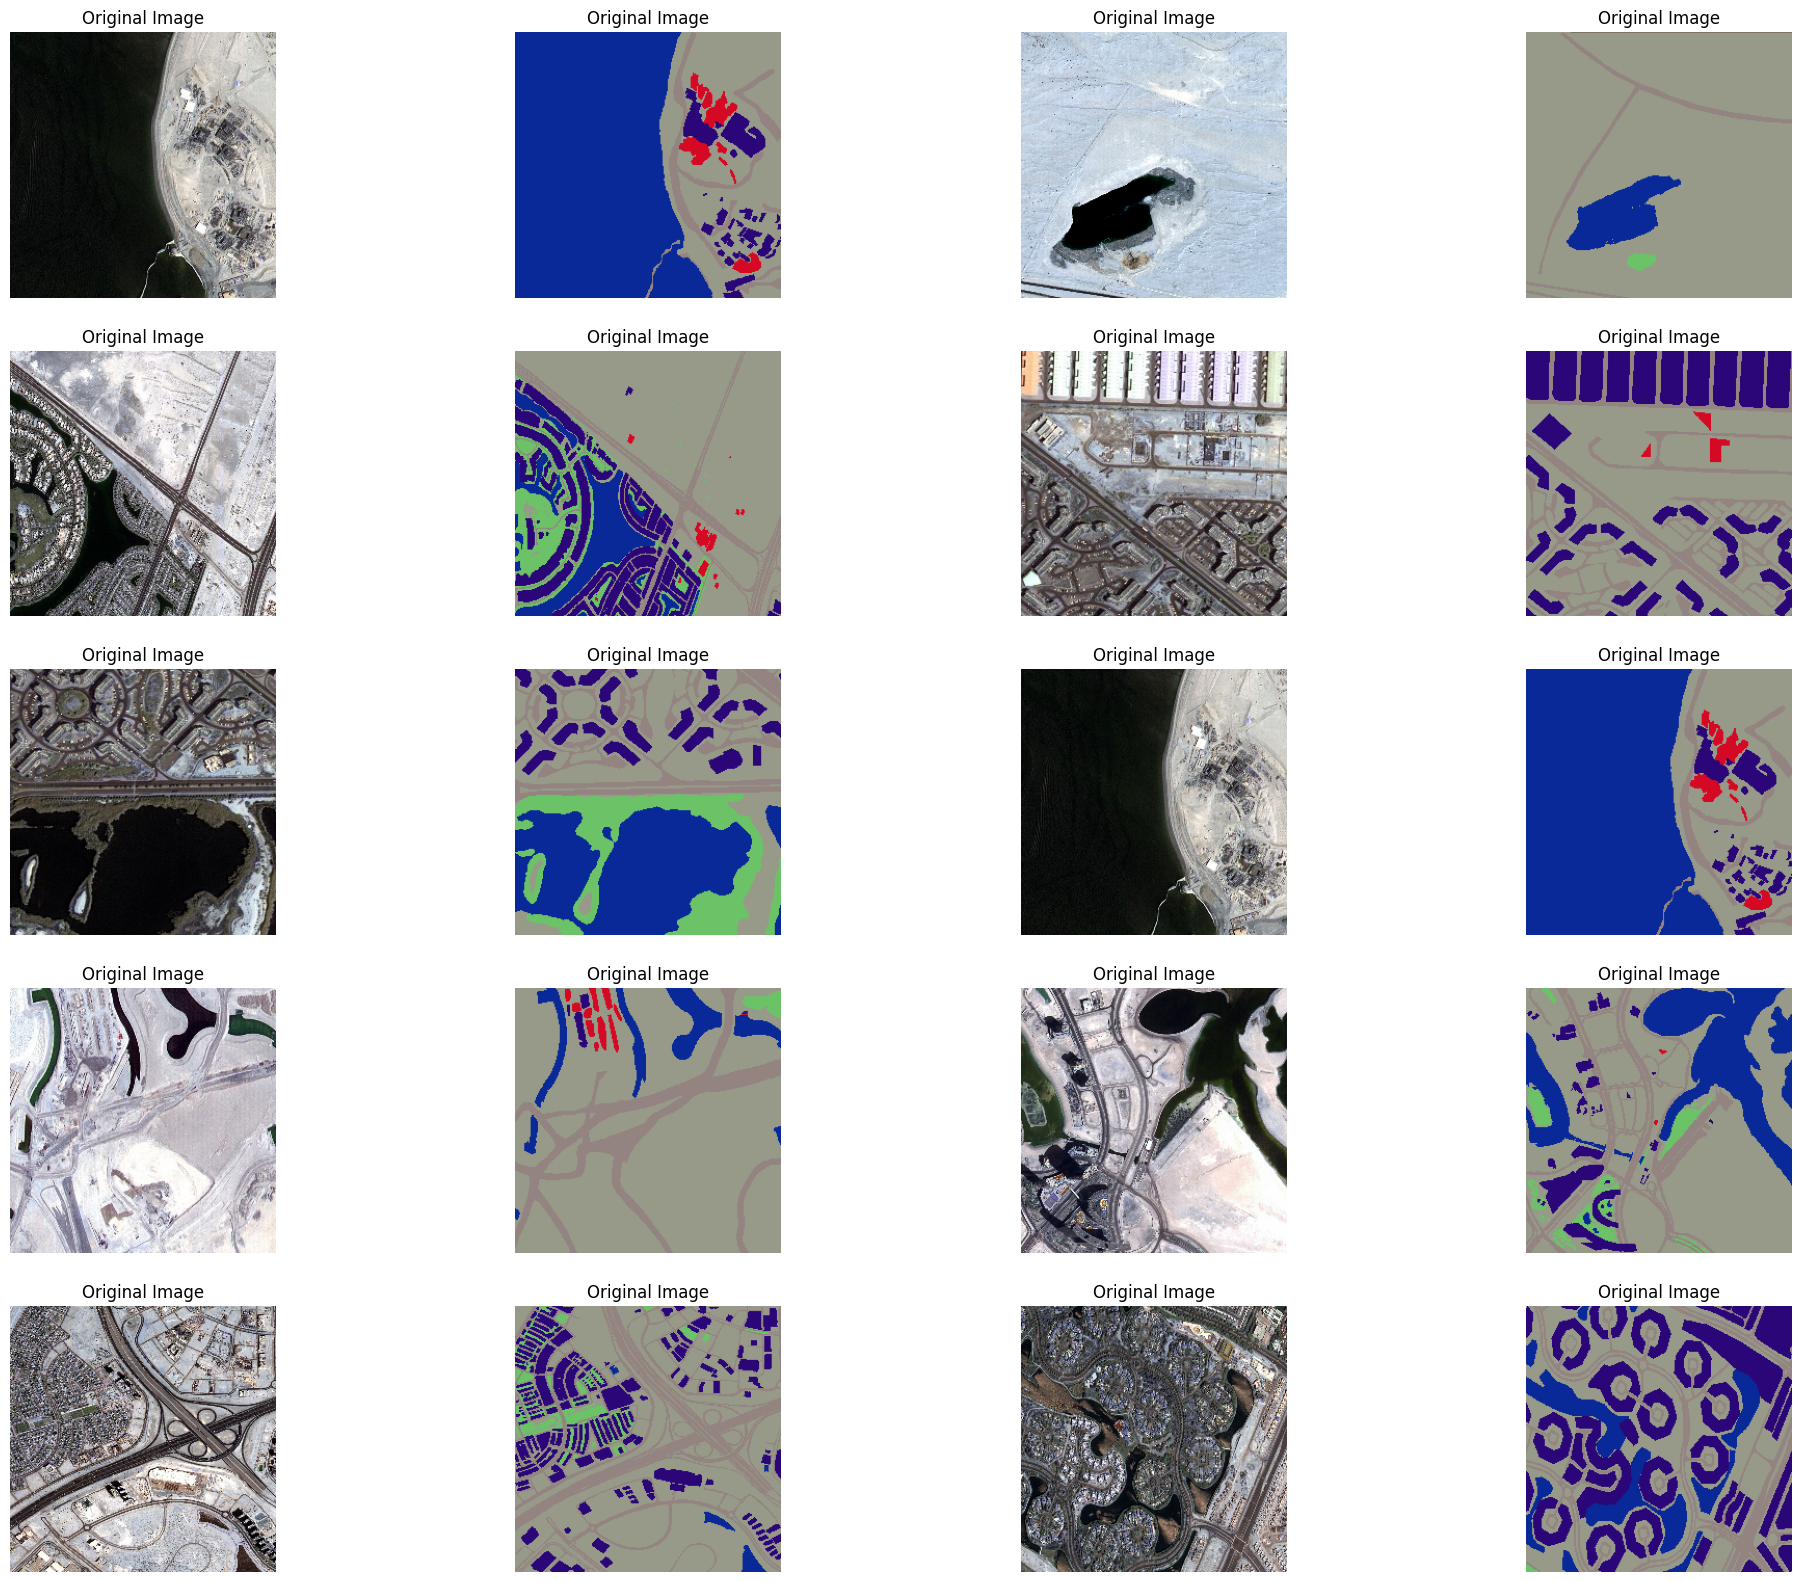

In [ ]:
import random
from torchvision import transforms as tfs

def tn_2_np(t):
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])

    rgb = True if len(t) == 3 else False

    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):

    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)

    return count + 1

def visualize(ds, n_ims):

    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]

    for idx, index in enumerate(indices):

        if count == n_ims + 1: break
        im, gt = ds[index]

        # First Plot
        count = plot(rows, cols, count, im = im)

        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True)

visualize(tr_dl.dataset, n_ims = 20)

Training Setup

In [ ]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

model = smp.Unet(classes = n_cls)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

import time
from tqdm import tqdm
from torch.nn import functional as F

class Metrics():

    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):

        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred

    def to_contiguous(self, inp): return inp.contiguous().view(-1)

    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()

        return float(match.sum()) / float(match.numel())

    def mIoU(self):

        with torch.no_grad():
            self.gt = torch.argmax(self.gt, dim = 1)

            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []

            for c in range(self.n_cls):

                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)

                else:

                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)

            return np.nanmean(iou_per_class)

    def loss(self): return self.loss_fn(self.pred_, torch.argmax(self.gt, dim = 1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time


Train And Validation

In [ ]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, save_path = "saved_models"):

    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 7
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")

    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0

        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):

            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()

            tr_iou_ += met.mIoU()

            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()

        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()


        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)

        if best_loss > (val_loss_):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        if val_loss_ > best_loss:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")

    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 50, save_prefix = "aerial")

Start training process...
Epoch 1 train process is started...


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


Epoch 1 validation process is started...


100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 26.541 secs
Train Loss         -> 1.231
Train PA           -> 0.568
Train IoU          -> 0.495
Validation Loss    -> 0.896
Validation PA      -> 0.716
Validation IoU     -> 0.653

Loss decreased from inf to 0.896!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 16/16 [00:04<00:00,  3.34it/s]


Epoch 2 validation process is started...


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 7.231 secs
Train Loss         -> 0.767
Train PA           -> 0.850
Train IoU          -> 0.741
Validation Loss    -> 0.461
Validation PA      -> 0.925
Validation IoU     -> 0.848

Loss decreased from 0.896 to 0.461!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 16/16 [00:04<00:00,  3.27it/s]


Epoch 3 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 5.656 secs
Train Loss         -> 0.624
Train PA           -> 0.869
Train IoU          -> 0.733
Validation Loss    -> 0.327
Validation PA      -> 0.950
Validation IoU     -> 0.892

Loss decreased from 0.461 to 0.327!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 16/16 [00:03<00:00,  4.52it/s]


Epoch 4 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 4.239 secs
Train Loss         -> 0.473
Train PA           -> 0.896
Train IoU          -> 0.780
Validation Loss    -> 0.281
Validation PA      -> 0.958
Validation IoU     -> 0.908

Loss decreased from 0.327 to 0.281!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 16/16 [00:04<00:00,  3.57it/s]


Epoch 5 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 5.540 secs
Train Loss         -> 0.407
Train PA           -> 0.896
Train IoU          -> 0.784
Validation Loss    -> 0.239
Validation PA      -> 0.958
Validation IoU     -> 0.908

Loss decreased from 0.281 to 0.239!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 16/16 [00:04<00:00,  3.51it/s]


Epoch 6 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 5.292 secs
Train Loss         -> 0.396
Train PA           -> 0.895
Train IoU          -> 0.774
Validation Loss    -> 0.698
Validation PA      -> 0.877
Validation IoU     -> 0.734

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 16/16 [00:03<00:00,  4.62it/s]


Epoch 7 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 4.213 secs
Train Loss         -> 0.346
Train PA           -> 0.908
Train IoU          -> 0.802
Validation Loss    -> 0.204
Validation PA      -> 0.956
Validation IoU     -> 0.903

Loss decreased from 0.698 to 0.204!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████| 16/16 [00:03<00:00,  4.49it/s]


Epoch 8 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 4.609 secs
Train Loss         -> 0.292
Train PA           -> 0.922
Train IoU          -> 0.829
Validation Loss    -> 0.206
Validation PA      -> 0.952
Validation IoU     -> 0.893

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████| 16/16 [00:05<00:00,  2.96it/s]


Epoch 9 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 6.158 secs
Train Loss         -> 0.294
Train PA           -> 0.918
Train IoU          -> 0.816
Validation Loss    -> 0.190
Validation PA      -> 0.959
Validation IoU     -> 0.909

Loss decreased from 0.206 to 0.190!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|██████████| 16/16 [00:03<00:00,  4.64it/s]


Epoch 10 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 4.134 secs
Train Loss         -> 0.323
Train PA           -> 0.906
Train IoU          -> 0.796
Validation Loss    -> 0.181
Validation PA      -> 0.951
Validation IoU     -> 0.892

Loss decreased from 0.190 to 0.181!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process is started...


100%|██████████| 16/16 [00:03<00:00,  4.64it/s]


Epoch 11 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch 11 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process results: 

Train Time         -> 4.140 secs
Train Loss         -> 0.263
Train PA           -> 0.924
Train IoU          -> 0.830
Validation Loss    -> 0.182
Validation PA      -> 0.952
Validation IoU     -> 0.894

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process is started...


100%|██████████| 16/16 [00:04<00:00,  3.43it/s]


Epoch 12 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Epoch 12 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process results: 

Train Time         -> 5.770 secs
Train Loss         -> 0.250
Train PA           -> 0.928
Train IoU          -> 0.830
Validation Loss    -> 0.200
Validation PA      -> 0.945
Validation IoU     -> 0.879

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process is started...


100%|██████████| 16/16 [00:04<00:00,  3.71it/s]


Epoch 13 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Epoch 13 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process results: 

Train Time         -> 5.012 secs
Train Loss         -> 0.201
Train PA           -> 0.937
Train IoU          -> 0.863
Validation Loss    -> 0.162
Validation PA      -> 0.957
Validation IoU     -> 0.906

Loss decreased from 0.200 to 0.162!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process is started...


100%|██████████| 16/16 [00:03<00:00,  4.37it/s]


Epoch 14 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch 14 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process results: 

Train Time         -> 4.377 secs
Train Loss         -> 0.250
Train PA           -> 0.922
Train IoU          -> 0.809
Validation Loss    -> 0.162
Validation PA      -> 0.960
Validation IoU     -> 0.912

Loss decreased from 0.162 to 0.162!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process is started...


100%|██████████| 16/16 [00:03<00:00,  4.36it/s]


Epoch 15 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Epoch 15 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process results: 

Train Time         -> 4.766 secs
Train Loss         -> 0.222
Train PA           -> 0.934
Train IoU          -> 0.848
Validation Loss    -> 0.193
Validation PA      -> 0.951
Validation IoU     -> 0.891

Loss did not decrease for 5 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process is started...


100%|██████████| 16/16 [00:05<00:00,  3.01it/s]


Epoch 16 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 16 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process results: 

Train Time         -> 6.024 secs
Train Loss         -> 0.189
Train PA           -> 0.942
Train IoU          -> 0.869
Validation Loss    -> 0.159
Validation PA      -> 0.958
Validation IoU     -> 0.907

Loss decreased from 0.193 to 0.159!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process is started...


100%|██████████| 16/16 [00:03<00:00,  4.85it/s]


Epoch 17 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 17 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process results: 

Train Time         -> 3.997 secs
Train Loss         -> 0.179
Train PA           -> 0.941
Train IoU          -> 0.870
Validation Loss    -> 0.170
Validation PA      -> 0.960
Validation IoU     -> 0.911

Loss did not decrease for 6 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process is started...


100%|██████████| 16/16 [00:03<00:00,  4.82it/s]


Epoch 18 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch 18 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process results: 

Train Time         -> 4.049 secs
Train Loss         -> 0.166
Train PA           -> 0.942
Train IoU          -> 0.875
Validation Loss    -> 0.152
Validation PA      -> 0.956
Validation IoU     -> 0.902

Loss decreased from 0.170 to 0.152!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process is started...


100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


Epoch 19 validation process is started...


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

Epoch 19 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process results: 

Train Time         -> 6.293 secs
Train Loss         -> 0.195
Train PA           -> 0.938
Train IoU          -> 0.853
Validation Loss    -> 0.161
Validation PA      -> 0.956
Validation IoU     -> 0.903

Loss did not decrease for 7 epoch(s)!
Stopping training process becuase loss value did not decrease for 7 epochs!
Train process is completed in 1.992 minutes.


learning Curves

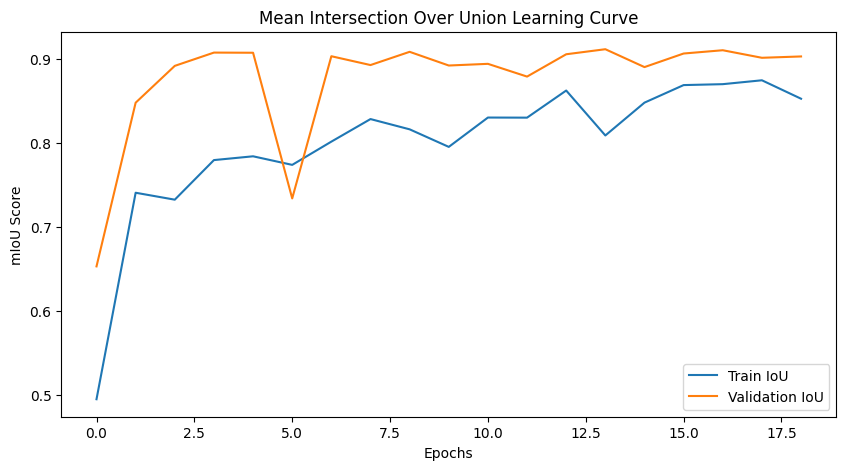

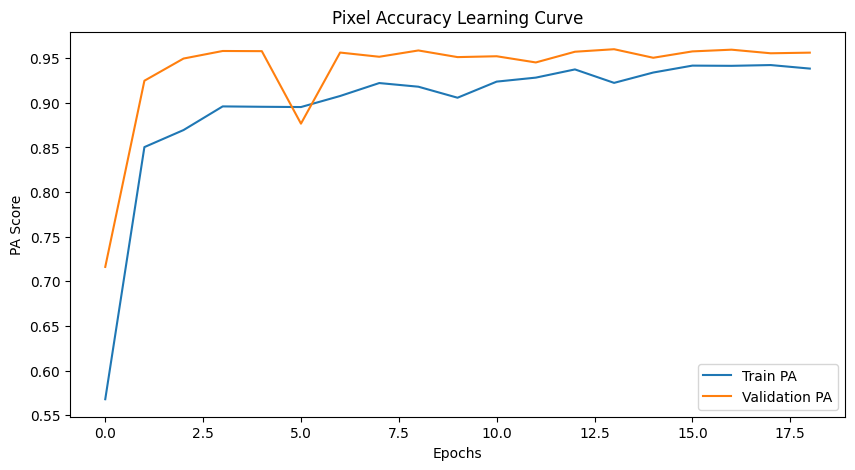

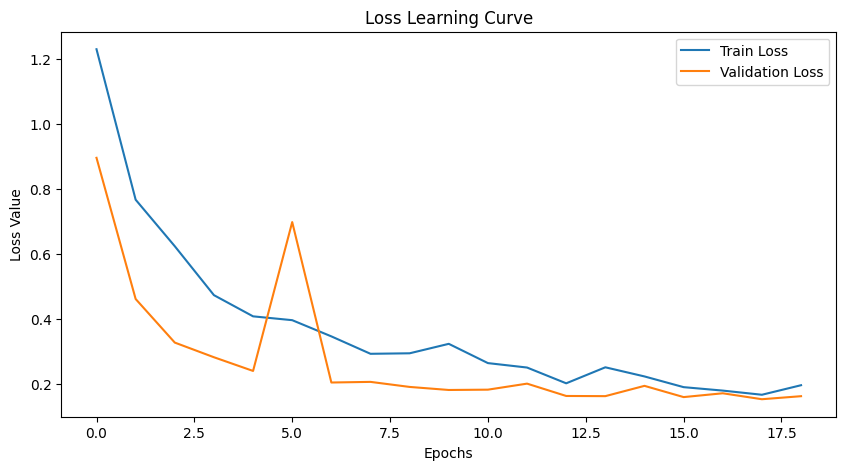

In [ ]:
class Plot():

    def __init__(self, res):

        self.res = res

        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU",
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")

        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA",
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")

        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss",
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")


    def plot(self, metric, label): plt.plot(self.res[metric], label = label)

    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()

    def visualize(self, metric1, metric2, label1, label2, title, ylabel):

        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)

Plot(history)

Inference

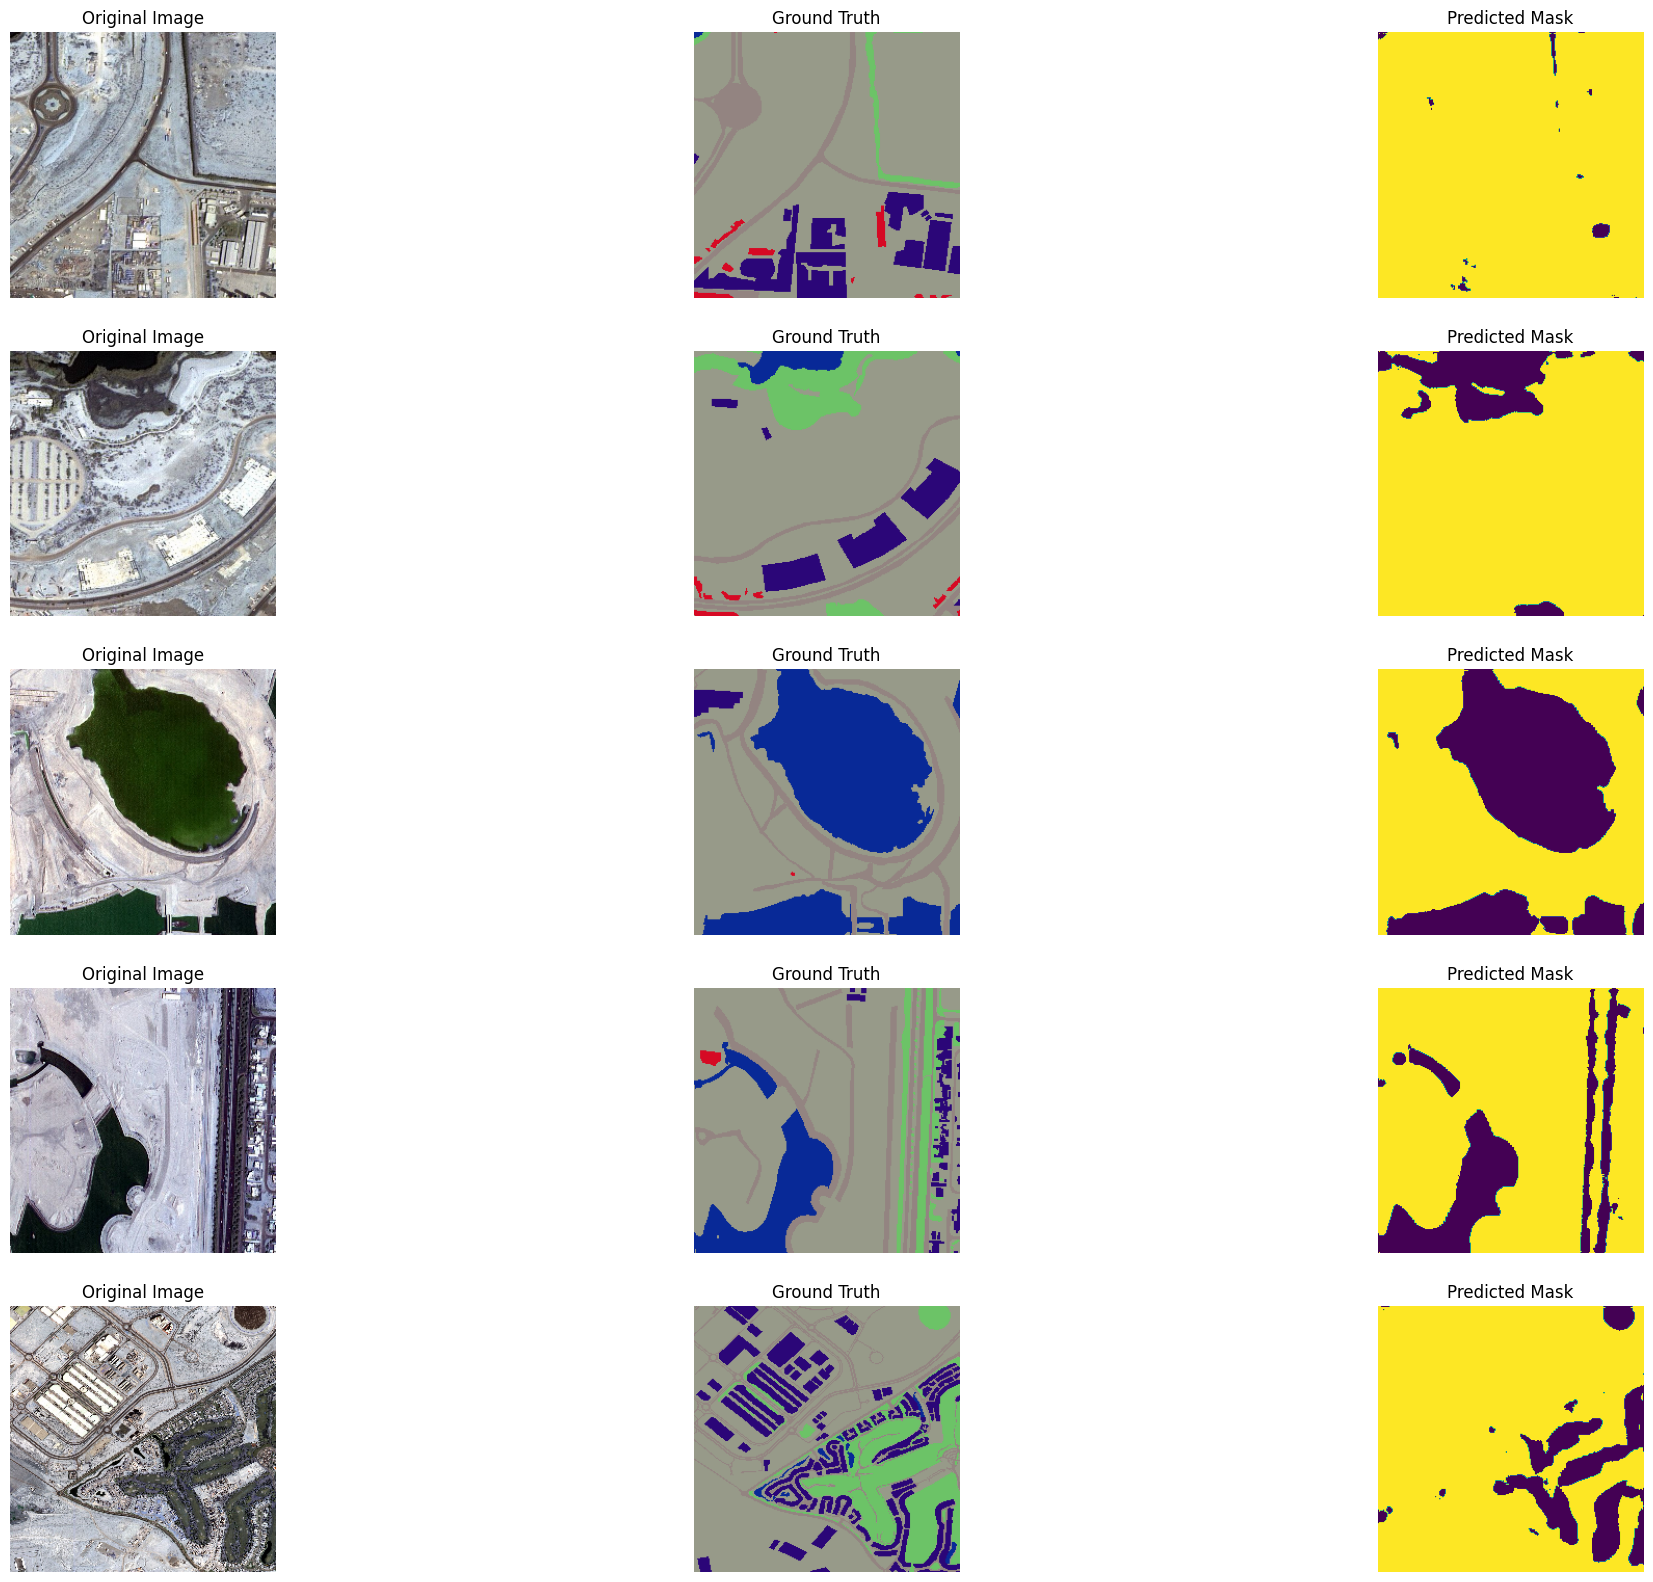

In [ ]:
def inference(dl, model, device, n_ims = 15):

    cols = n_ims // 3; rows = n_ims // cols

    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)

    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break

        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt, gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")

model = torch.load("/content/saved_models/aerial_best_model.pt")
inference(test_dl, model = model, device = device)